In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import tree

In [2]:
data = pd.read_csv('employee_churn_data.csv')
data.tail(9540)

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no
...,...,...,...,...,...,...,...,...,...,...
9535,operations,0,0.610988,4,medium,8.0,0.543641,0,188.155738,yes
9536,logistics,0,0.746887,3,medium,8.0,0.549048,0,188.176164,yes
9537,operations,0,0.557980,3,low,7.0,0.705425,0,186.531008,yes
9538,IT,0,0.584446,4,medium,8.0,0.607287,1,187.641370,yes


In [3]:
df = data.copy()

In [4]:
# Checking clean shape and nº of employees
rows, cols = df.shape 
departments = df.department.unique().shape[0]

print(f'Dataset Shape\n\nNumber of Employee Observations : {rows}\nNumber of features : {cols}\nNumber of different departments : {departments}')

Dataset Shape

Number of Employee Observations : 9540
Number of features : 10
Number of different departments : 10


In [5]:
# Checking general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 745.4+ KB


In [6]:
# Department with sorted number of employee turnovers: from highest to lowest
no_turnover = df[df.left == 'yes'].groupby('department').left.count().sort_values()

no_turnover.to_frame()

,left
department,
finance,108
IT,110
logistics,111
admin,119
support,212
marketing,243
operations,436
engineering,437
retail,471


In [7]:
turnover_rate = df.left.value_counts()/len(df)
turnover_rate

no     0.708176
yes    0.291824
Name: left, dtype: float64

Looks like about 29% of the employees left.

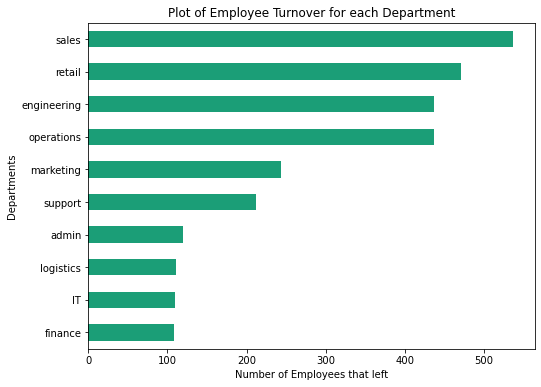

In [8]:
# Department with sorted number of employee turnovers: from highest to lowest

fig, ax = plt.subplots(figsize=(8, 6))
no_turnover.plot.barh(ax=ax, title="Plot of Employee Turnover for each Department", colormap='Dark2')
plt.xlabel("Number of Employees that left")
plt.ylabel("Departments")
plt.show()

1. Which department has the highest employee turnover? Which one has the lowest?

The Department with the highest number of employee turnover as seen above is the Sales department,

while the departments with the least is the Finance and IT department.

In [9]:
# convert all relevant features into categorical variables
category_vars = ['department', 'promoted', 'salary', 'bonus', 'left']
numeric_vars = ['review', 'projects', 'tenure', 'avg_hours_month']

data[category_vars] = data[category_vars].apply(lambda x: x.astype('category'))

# rename specific categories
binary_changes = {0: "no", 1: "yes"}
data[['promoted', 'bonus']] = data[['promoted', 'bonus']].apply(lambda x: x.cat.rename_categories(binary_changes))

# change 'tenure' from a float to an integer
data['tenure'] = data['tenure'].astype('int64')

In [10]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   department     9540 non-null   category
 1   promoted       9540 non-null   category
 2   review         9540 non-null   float64 
 3   projects       9540 non-null   int64   
 4   salary         9540 non-null   category
 5   tenure         9540 non-null   int64   
 6   satisfaction   9540 non-null   float64 
 7   bonus          9540 non-null   category
 8   avg_hrs_month  9540 non-null   float64 
 9   left           9540 non-null   category
dtypes: category(5), float64(3), int64(2)
memory usage: 420.2 KB


,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,no,0.577569,3,low,5,0.626759,no,180.866070,no
1,operations,no,0.751900,3,medium,6,0.443679,no,182.708149,no
2,support,no,0.722548,3,medium,6,0.446823,no,184.416084,no
3,logistics,no,0.675158,4,high,8,0.440139,no,188.707545,no
4,sales,no,0.676203,3,high,5,0.577607,yes,179.821083,no


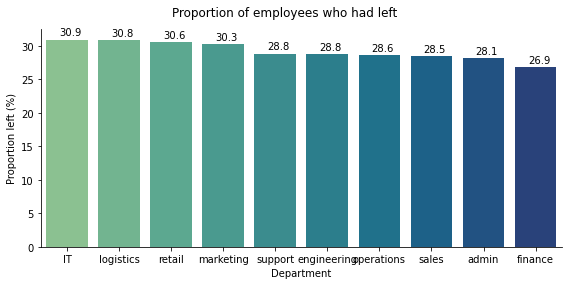

In [11]:
# left by department
# create the summary table of proportions
temp = data.groupby("department")["left"].value_counts(normalize=True)
temp = pd.DataFrame(temp).reset_index()
temp.columns = ['department', 'left', 'prop']
temp.prop = temp.prop.mul(100)
temp = temp[temp.left == "yes"]
temp = temp.sort_values("prop", ascending=False).reset_index()

# create the x-axis sort order
dept_order = list(temp["department"])

# plot the turnover rates by department
p = sns.catplot(x="department", y="prop", data=temp, order=dept_order, kind="bar", 
                height=4, aspect=2, saturation=5, palette="crest")
p.set_axis_labels("Department", "Proportion left (%)")
p.fig.subplots_adjust(top=0.9)
p.fig.suptitle("Proportion of employees who had left");

# extract the matplotlib axes_subplot objects from the FacetGrid
ax = p.facet_axis(0,0)
# iterate through the axes patches
for pat in ax.patches:
    ax.text(pat.get_x() + 0.25, 
            pat.get_height() * 1.02, 
           '{0:.1f}'.format(pat.get_height()),
            color='black', 
            rotation = 'horizontal', 
            size = 'medium')

The overall employee turnover rate was 29.2%, This chart clearly indicated that there were slightly differing rates by department. Finance was the lowest at 26.9% and IT was the highest at 30.9%, closely followed by Logistics at 30.8%

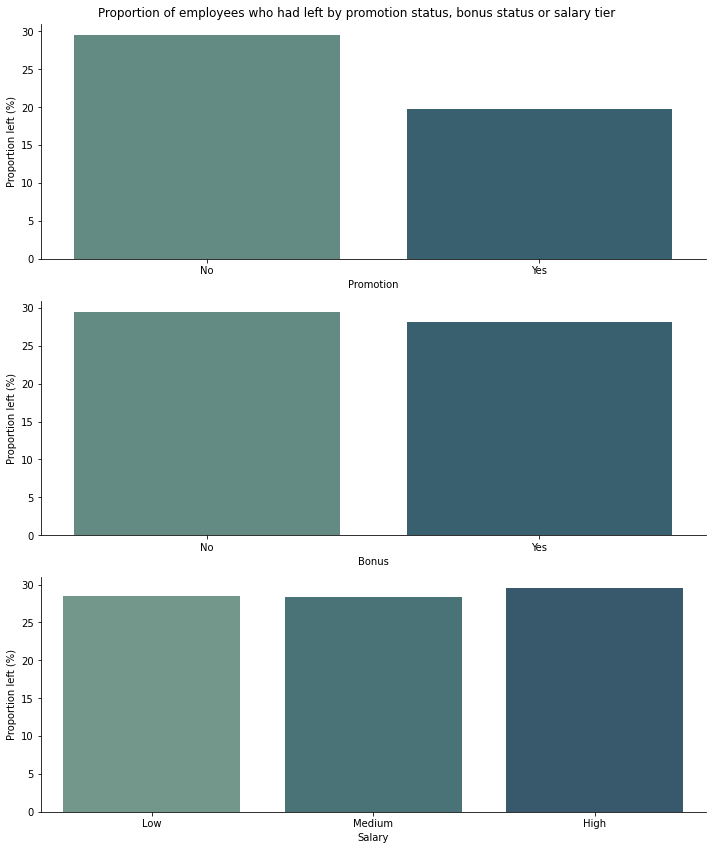

In [12]:
# create the summary tables of proportions
temp_p = data.groupby("promoted")["left"].value_counts(normalize=True)
temp_p = pd.DataFrame(temp_p).reset_index()
temp_p.columns = ['promoted', 'left', 'prop']
temp_p.prop = temp_p.prop.mul(100)
temp_p = temp_p[temp_p.left == "yes"]

temp_b = data.groupby("bonus")["left"].value_counts(normalize=True)
temp_b = pd.DataFrame(temp_b).reset_index()
temp_b.columns = ['bonus', 'left', 'prop']
temp_b.prop = temp_b.prop.mul(100)
temp_b = temp_b[temp_b.left == "yes"]

temp_s = data.groupby("salary")["left"].value_counts(normalize=True)
temp_s = pd.DataFrame(temp_s).reset_index()
temp_s.columns = ['salary', 'left', 'prop']
temp_s.prop = temp_s.prop.mul(100)
temp_s = temp_s[temp_s.left == "yes"]

# create the charts
fig, axs = plt.subplots(3, 1, figsize=(10,12))

p = sns.barplot(x="promoted", y="prop", data=temp_p, saturation=0.5, palette="crest", ax=axs[0])
p.set(xlabel="Promotion", ylabel="Proportion left (%)")
p.set_xticklabels(["No", "Yes"])

b = sns.barplot(x="bonus", y="prop", data=temp_b, saturation=0.5, palette="crest", ax=axs[1])
b.set(xlabel="Bonus", ylabel="Proportion left (%)")
b.set_xticklabels(["No", "Yes"])

s = sns.barplot(x="salary", y="prop", data=temp_s, saturation=0.5, palette="crest", ax=axs[2])
s.set(xlabel="Salary", ylabel="Proportion left (%)")
s.set_xticklabels(["Low", "Medium", "High"])

sns.despine()
fig.suptitle("Proportion of employees who had left by promotion status, bonus status or salary tier")
fig.tight_layout();

he proportions of employees by turnover status, against whether they had received a promotion or bonus in the last 24 months, and their salary range. The first subplot indicates that a higher proportion of employees had stayed with the organisation if they had received a promotion. However, the second two indicate that whether an employee had received a bonus or not, and what level of salary they received had had no significant impact (non-statistically) on turnover status.

In [13]:
#Data Transformation

# Changing the columns names to title text
df.columns = [i.title() for i in df.columns]

# Changing the text feature's values to capitalized text
df[['Department','Salary','Left']] = df[['Department','Salary','Left']].apply(lambda x: x.str.capitalize())

# Changing Left feature to binary 
df['Left'] = df['Left'].apply(lambda x: 0 if x == 'No' else 1)

# Changing Salary feature to numerical 
df['Salary'] = df['Salary'].apply(lambda x: 1 if x == 'Low' else (2 if x == 'Medium' else 3))

# Rounding Review, Satisfaction and Avg_Hrs_Month
df[['Review','Satisfaction','Avg_Hrs_Month']] = df[['Review','Satisfaction','Avg_Hrs_Month']].apply(lambda x: round(x,2))

df.head()

,Department,Promoted,Review,Projects,Salary,Tenure,Satisfaction,Bonus,Avg_Hrs_Month,Left
0,Operations,0,0.58,3,1,5.0,0.63,0,180.87,0
1,Operations,0,0.75,3,2,6.0,0.44,0,182.71,0
2,Support,0,0.72,3,2,6.0,0.45,0,184.42,0
3,Logistics,0,0.68,4,3,8.0,0.44,0,188.71,0
4,Sales,0,0.68,3,3,5.0,0.58,1,179.82,0


**Exploratory Data Analysis**

Getting a better understanding of data

Identifying various data patterns

Getting a better understanding of the problem statement

In [ ]:
# Summary statistics
df.describe().T

In [ ]:
# Correlations analysis
#plot
cmap = sns.color_palette('Greens', as_cmap=True)

plt.figure(figsize = (11, 5))
sns.heatmap(data = df.corr(), annot = True, cmap = cmap)

#customize
plt.title('Correlation Heatmap',fontsize = 25, fontweight = 'bold')

plt.show()

Findings from the correlation Matrix and Heatmap

Positively Correlated Features: review vs left: 0.3 tenure vs avg_hrs_month: 0.98 

Negatively Correlated Features: review vs satisfaction: -0.35

Summary

From the heatmap, there is a positive(+) correlation between review, left, tenure and avg_hrs_month. 

This can be interpreted as:

The employees decided to leave or stay based on the review they recieved. 

The avg_hrs_month is definitely high for the employees working for more number of years. 

For the negative(-) correlation the review and satisfaction are highly correlated. This can be interpreted as:

The employees were not satisfied with the reviews they received.


In [27]:
# Setting Style 
plt.style.use('seaborn')

C:\Users\mswaa\AppData\Local\Temp/ipykernel_16568/3104868377.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Promoted']=df['Promoted']
C:\Users\mswaa\AppData\Local\Temp/ipykernel_16568/3104868377.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Bonus']=df['Bonus']
C:\Users\mswaa\AppData\Local\Temp/ipykernel_16568/3104868377.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

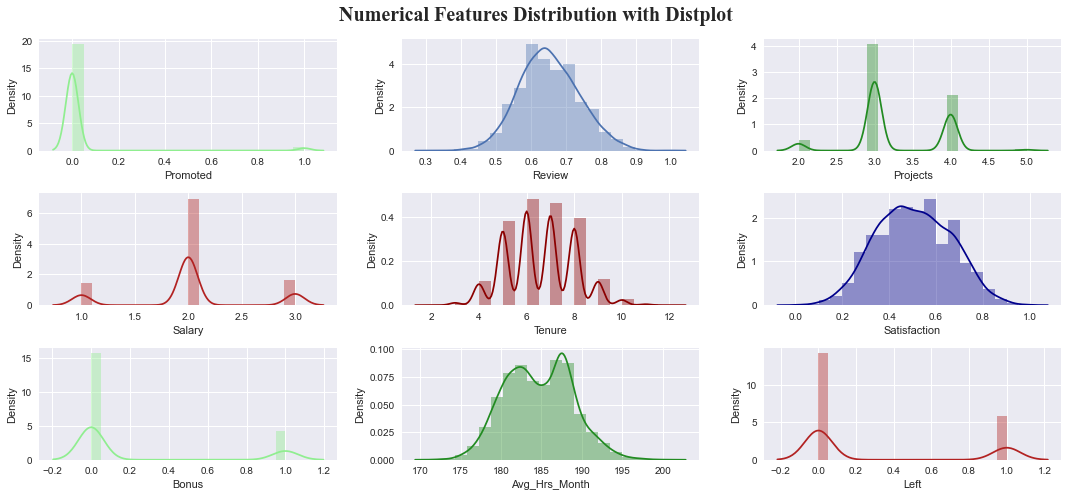

In [28]:
# (non-binary)

#subseting numeric features
tmp = df.select_dtypes(include = ['float64', 'int64'])
tmp['Promoted']=df['Promoted']
tmp['Bonus']=df['Bonus']
tmp['Left']=df['Left']

# for col, rows in tmp.items(): 
#     if col in tmp:
#         if rows.value_counts().shape[0] == 2:
            # del tmp[col]
            
#plot
fig, ax = plt.subplots(3, 3, figsize = (15,7)) 

sns.distplot(tmp.iloc[:,0], bins=20, hist_kws={'alpha': 0.4}, color='lightgreen', ax = ax[0,0])
sns.distplot(tmp.iloc[:,1], bins=20, hist_kws={'alpha': 0.4}, ax = ax[0,1]) 
sns.distplot(tmp.iloc[:,2], bins=20, hist_kws={'alpha': 0.4}, color='forestgreen', ax = ax[0,2])
sns.distplot(tmp.iloc[:,3], bins=20, hist_kws={'alpha': 0.4}, color='firebrick', ax = ax[1,0]) 
sns.distplot(tmp.iloc[:,4], bins=20, hist_kws={'alpha': 0.4}, color='darkred', ax = ax[1,1])  
sns.distplot(tmp.iloc[:,5], bins=20, hist_kws={'alpha': 0.4}, color='darkblue', ax = ax[1,2])
sns.distplot(tmp.iloc[:,6], bins=20, hist_kws={'alpha': 0.4}, color='lightgreen', ax = ax[2,0])
sns.distplot(tmp.iloc[:,7], bins=20, hist_kws={'alpha': 0.4}, color='forestgreen', ax = ax[2,1])
sns.distplot(tmp.iloc[:,8], bins=20, hist_kws={'alpha': 0.4}, color='firebrick', ax = ax[2,2])

#customize
plt.rcParams['font.family'] = 'Times New Roman'
plt.suptitle('Numerical Features Distribution with Distplot', fontsize = 20, fontweight = 'bold') 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None) 
        
plt.tight_layout()

In [29]:
tmp.head()

,Promoted,Review,Projects,Salary,Tenure,Satisfaction,Bonus,Avg_Hrs_Month,Left
0,0,0.58,3,1,5.0,0.63,0,180.87,0
1,0,0.75,3,2,6.0,0.44,0,182.71,0
2,0,0.72,3,2,6.0,0.45,0,184.42,0
3,0,0.68,4,3,8.0,0.44,0,188.71,0
4,0,0.68,3,3,5.0,0.58,1,179.82,0


In [19]:
# tmp['Salary']=df['Salary']

In [20]:
# tmp['Salary-Low']=tmp['Salary']==1
# tmp['Salary-Medium']=tmp['Salary']==2
# tmp['Salary-High']=tmp['Salary']==3

In [21]:
# tmp.head()

In [22]:
# del tmp['Salary']

In [23]:
# tmp.head()

In [30]:
tmp.columns

Index(['Promoted', 'Review', 'Projects', 'Salary', 'Tenure', 'Satisfaction',
       'Bonus', 'Avg_Hrs_Month', 'Left'],
      dtype='object')

In [31]:
y = tmp['Left']
y = np.array(y)
print(y.shape)

(9540,)


In [33]:
X = tmp[['Promoted', 'Review', 'Projects', 'Tenure', 'Satisfaction', 'Bonus',
       'Avg_Hrs_Month', 'Salary']]

X = np.array(X).astype(float)
print(X.shape)

(9540, 8)


In [ ]:
# from sklearn.model_selection import train_test_split

In [34]:
X=df[['Promoted', 'Review', 'Projects', 'Salary', 'Tenure',
       'Satisfaction', 'Bonus', 'Avg_Hrs_Month']]
y=df['Left']

In [35]:
print(X.shape)
print(y.shape)

(9540, 8)
(9540,)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=7)

In [37]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7632, 8)
(7632,)
(1908, 8)
(1908,)


In [38]:
X_train.head()

,Promoted,Review,Projects,Salary,Tenure,Satisfaction,Bonus,Avg_Hrs_Month
7861,0,0.70,3,2,9.0,0.53,1,193.38
1791,0,0.68,3,2,5.0,0.58,0,180.60
9042,0,0.63,3,2,8.0,0.56,1,188.02
6356,0,0.65,4,2,6.0,0.29,0,183.96
3492,0,0.79,4,2,6.0,0.32,0,181.94


In [39]:
X_test.head()

,Promoted,Review,Projects,Salary,Tenure,Satisfaction,Bonus,Avg_Hrs_Month
4483,0,0.79,3,2,5.0,0.20,0,181.30
4764,0,0.68,3,2,6.0,0.49,0,182.19
7109,0,0.75,3,2,7.0,0.30,0,187.39
6212,0,0.62,3,3,8.0,0.36,0,188.89
7639,0,0.53,3,1,6.0,0.33,0,183.91


In [40]:
y_train.head()

7861    0
1791    0
9042    1
6356    0
3492    1
Name: Left, dtype: int64

In [41]:
y_test.head()

4483    1
4764    1
7109    0
6212    0
7639    0
Name: Left, dtype: int64

# Decision Tree

In [42]:
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,min_samples_leaf=5)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=5, random_state=100)

In [43]:
feature_names = ['Promoted', 'Review', 'Projects', 'Salary', 'Tenure',
       'Satisfaction', 'Bonus', 'Avg_Hrs_Month']
target_name = ['True', 'False']

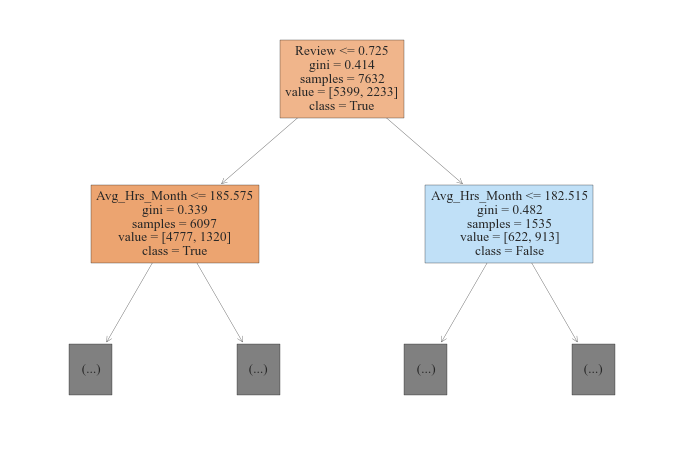

In [44]:
fig = plt.figure(figsize=(12,8))
_ = tree.plot_tree(clf_gini, 
                   feature_names=feature_names,  
                   class_names=target_name,
                   max_depth = 1,
                   filled=True)



In [45]:
import time
import numpy as np

start_time = time.time()
importances = clf_gini.feature_importances_
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.000 seconds


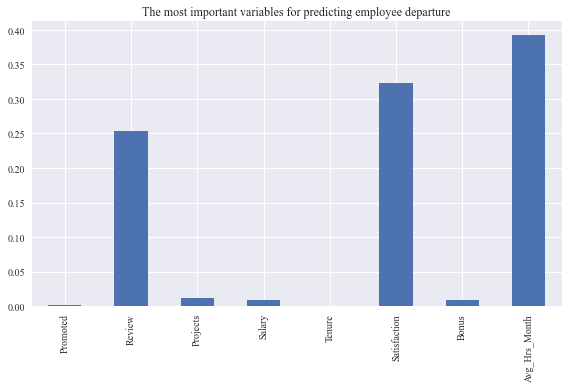

In [46]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("The most important variables for predicting employee departure")
ax.set_ylabel("")
fig.tight_layout()

In [47]:
X_sample = df.sample(1, random_state=50)
X_sample

,Department,Promoted,Review,Projects,Salary,Tenure,Satisfaction,Bonus,Avg_Hrs_Month,Left
3440,Sales,0,0.89,4,2,4.0,0.31,0,177.64,1


In [48]:
clf_gini.predict(X_sample[feature_names])

array([1], dtype=int64)

In [49]:
print(classification_report(clf_gini.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1396
           1       0.69      0.75      0.72       512

    accuracy                           0.84      1908
   macro avg       0.80      0.81      0.81      1908
weighted avg       0.85      0.84      0.85      1908

